In [28]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [2]:
r = 0.2
N = 110
M = round(Int, N*(1-r))
f = 1-3r
AA = permutedims(ldpc_matrix(N,M,3M,[0,1-f,f],[0, 0, 1]))
src = bitrand(N)
BB, ind = findbasis_slow(BitMatrix(AA));

In [3]:
@time exact_wef(BB, [src]);

  1.993268 seconds (2.81 M allocations: 153.900 MiB, 2.71% gc time, 66.29% compilation time)


In [4]:
# plot_wef(h[1], size=(400,200))

## Vary the rate

In [5]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../../telegram/notifications.jl")
using Base.Threads, Statistics
nthreads()

22

In [230]:
W = 16
Rs = (1:4) // W
nn = 7
navg = 30 * ones(Int, nn)
# nmax is set to the largest value of n so that the number of codewords (hence the cost)
#  is fixed to something like 2^25
nmax(R) = (30 / R ÷ W)
nmaxes(R, nn) = begin
    nm = nmax(R)
    k = max(1, floor(Int, nm/nn))
    nm-nn*k+1 <= 0 && (k=1)
    [16*i for i in nm-nn*k+1:k:nm]
end
ns = [nmaxes(r, nn) for r in Rs]
nsources = 50
d = [[fill(NaN, navg[i]) for i in eachindex(ns[a])] for a in eachindex(Rs)]
wef_zero = [[[zeros(Int, ns[a][i]) for _ in 1:navg[i]] for i in eachindex(ns[a])] for a in eachindex(Rs)]
t = fill(NaN, length(ns));

In [231]:
ns

4-element Vector{Vector{Int64}}:
 [48, 112, 176, 240, 304, 368, 432]
 [32, 64, 96, 128, 160, 192, 224]
 [64, 80, 96, 112, 128, 144, 160]
 [16, 32, 48, 64, 80, 96, 112]

In [ ]:
@telegram "Exact enumeration-larger sizes" for (i,R) in enumerate(Rs)
    println("Rate $i of ", length(Rs))
    tt = @timed for (a,n) in enumerate(ns[i])
        println("### Size $a of ", length(ns[i]))
        flush(stdout)
        m = round(Int, n*(1-R))
        f3 = 1-3R
        Λ = [0,1-f3,f3]
        K = [0, 0, 1]
        nedges = 3m
        @threads for j in 1:navg[a]  
            H = permutedims(ldpc_matrix(n,m,nedges,Λ,K))
            s = [bitrand(n) for _ in 1:nsources]
            B, indep = findbasis_slow(BitMatrix(H))
            rtrue = size(B,2) / size(B,1)
            if rtrue == R
                h0, h, mins = exact_wef(B, s, showprogress=false)
                wef_zero[i][a][j] = h0
                d[i][a][j] = mean(mins)
            end
        end
    end
    t[i] = tt.time
    d
end

Rate 1 of 4
### Size 1 of 7
### Size 2 of 7
### Size 3 of 7
### Size 4 of 7
### Size 5 of 7
### Size 6 of 7


In [246]:
[Rs t]

4×2 Matrix{Float64}:
 0.0625   273.566
 0.125    456.11
 0.1875  1779.23
 0.25     344.259

In [247]:
d_avg = [[mean(filter(!isnan, d[a][i])) for i in eachindex(ns[a])] for a in eachindex(Rs)]
d_std = [[std(filter(!isnan, d[a][i]))/sqrt(length(filter(!isnan, d[a][i]))) for i in eachindex(ns[a])] for a in eachindex(Rs)];

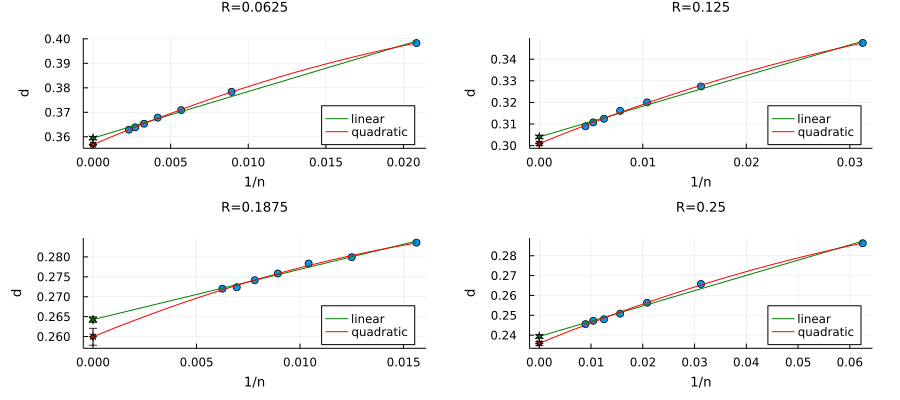

In [248]:
using DataFrames, GLM
d_avg_ = reduce(hcat, d_avg)
d_std_ = reduce(hcat, d_std)
qs = zeros(length(Rs))
qs2 = zeros(length(Rs))
ms = copy(qs)
qs_err = copy(qs)
qs2_err = copy(qs)
plts = Plots.Plot[]
for i in eachindex(Rs)
    x = 1 ./ ns[i]
    x_range = LinRange(0, maximum(x), 100)
    y = d_avg_[:,i]
    data = DataFrame(X=x, Y=y)
    ols = lm(@formula(Y ~ X), data)
    qs[i], ms[i] = coef(ols)
    qs_err[i] = stderror(ols)[1]
    ols2 = lm(@formula(Y ~ X + X^2), data)
    qs2[i], b, c = coef(ols2)
    qs2_err[i] = stderror(ols2)[1]
    plt = scatter(x, y, xlabel="1/n", ylabel="d", label="")
    plot!(plt, x_range, x_range*ms[i] .+ qs[i], title="R=$(float(Rs[i]))", titlefontsize=9, label="linear", 
        legend=:bottomright, c=:green)
    scatter!(plt, [0], [qs[i]], yerr=[qs_err[i]], c=:green, label="", m=:star6)
    plot!(plt, x_range, x_range.^2*c .+ x_range*b .+ qs2[i], title="R=$(float(Rs[i]))", titlefontsize=9, 
        label="quadratic", c=:red)
    scatter!(plt, [0], [qs2[i]], yerr=[qs2_err[i]], c=:red, label="", m=:star8, labelfontsize=9)
    push!(plts, plt)
end
plot(plts..., size=(900,400), margin=5Plots.mm)

In [249]:
# using DelimitedFiles
# open("exact_enum.txt", "w") do io
#    writedlm(io, Rs')
#     writedlm(io, reduce(hcat, d_avg)')
#     writedlm(io, reduce(hcat, d_std)')
#     writedlm(io, )
# end

In [250]:
ns_ = reduce(hcat, ns)

7×4 Matrix{Int64}:
  48   32   64   16
 112   64   80   32
 176   96   96   48
 240  128  112   64
 304  160  128   80
 368  192  144   96
 432  224  160  112

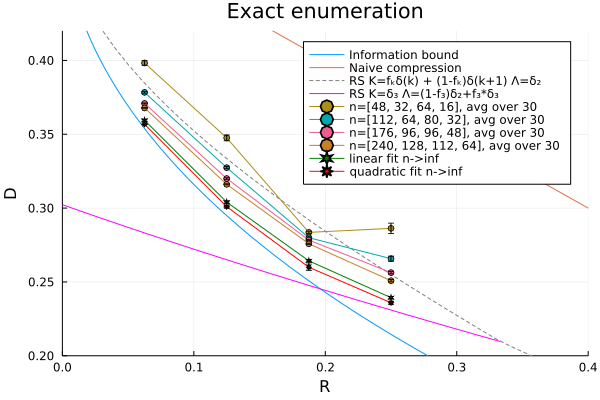

In [251]:
ns_ = reduce(hcat, ns)
pl = plot_rdb(f3=true)
for (j,n) in enumerate(ns)
    plot!(pl, Rs, d_avg_[j,:], yerr=d_std_[j,:], ms=3, label="n=$(ns_[j,:]), avg over $(navg[j])", marker=:o)
end
plot!(pl, title="Exact enumeration")
plot!(pl, Rs, qs, yerr=qs_err, ms=3, label="linear fit n->inf", marker=:star6, c=:green)
plot!(pl, Rs, qs2, yerr=qs2_err, ms=3, label="quadratic fit n->inf", marker=:star8, c=:red)
plot(pl,  xlims=(0, 0.4), ylims=(0.2, 0.42))

Runtime: 0.8 hours


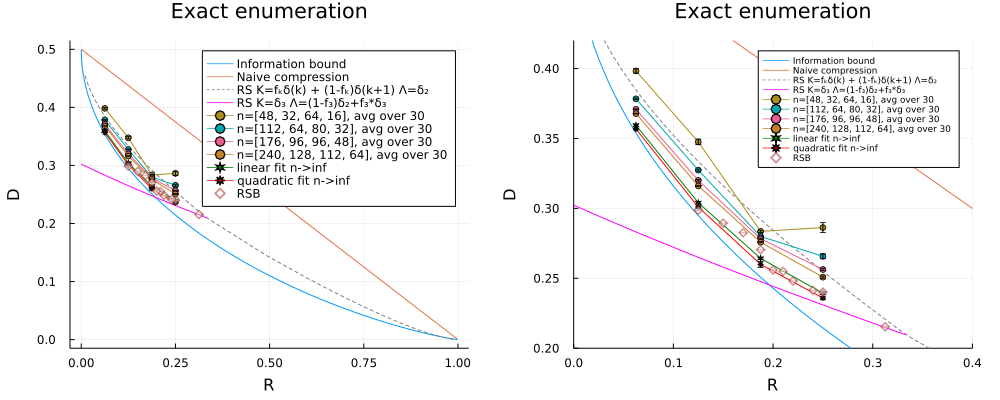

In [252]:
yopt_data = readdlm("yopt_data.txt")
t_hours = sum(t) / 3600
println("Runtime: ", round(t_hours,digits=1), " hours")
# Rs_rsb_23, Ds_rsb_23, Ds_er_rsb_23 = (0.11:0.02:0.33, [0.2977365737135704, 0.29679166785456546, 0.29575210731434554, 0.2949943231803669, 0.29397756485409976, 0.2501368753571527, 0.2411632189267363, 0.23388637157790765, 0.22714230559385223, 0.22128279206129292, 0.21565456260060245, 0.21012801774847617], [9.010253981269411e-5, 0.00018398776528276, 8.403118148946889e-5, 0.00015897456190779003, 9.16495914260236e-5, 0.0001709187426321453, 0.00017466109542782523, 0.000173980573936482, 0.0002413785375950678, 0.0003529835098745958, 0.00027606828090559466, 0.0004617280214407081])
# Rs_rsb = [0.25, 0.24, 0.22, 0.21, 0.2]
# y_rsb = vec([1.0 0.8 0.6 0.6 0.5])
# Ds_rsb = vec([0.24011787600556012 0.2414476621129465  0.24807018468086312 0.25495222929686445 0.2559480964548462])
# Ds_rsb_err = vec([0.000159658045833383    0.00017446890849328505  0.00010732745566573257  0.0001310842611345421   0.00027291305140915954])
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:]
M = readdlm("bp_dec_zeroleaves.txt")
R_bp_dec = M[:,1]
D_bp_dec_avg = M[:,2]
D_bp_dec_std = M[:,3]
plot!(pl, legendfontsize=6)
scatter!(pl, Rs_rsb, Ds_rsb, yerr=Ds_rsb_err, label="RSB", m=:diamond, msc=:brown, markeralpha=0.5, msw=2, c=:white)
pl2 = deepcopy(pl)
# plot!(pl2, Rs_rsb_23, Ds_rsb_23, m=:diamond, label="RSB y=0.5")
# scatter!(pl2, [0.24, 0.25], [0.2414, 0.2401], label="RSB", m=:diamond, msc=:brown, markeralpha=0.5, msw=2, c=:white)
plot!(pl2, xlims=(0, 0.4), ylims=(0.2, 0.42), legendfontsize=6)
# plot!(pl, R_bp_dec, D_bp_dec_avg, m=:x, label="BP+dec")
plot(pl, pl2, size=(1000,400), margin=5Plots.mm, dpi=1000)

In [ ]:
savefig("exact_enum.pdf")

## WEF

In [253]:
include("../code/exact_enum.jl")

plot_wef_prob (generic function with 1 method)

In [254]:
correct = [[[!isnan(d[i][j][k]) for k in 1:navg[j]] for j in eachindex(ns[i])] for i in eachindex(Rs)];

WEF wrt the zero codeword


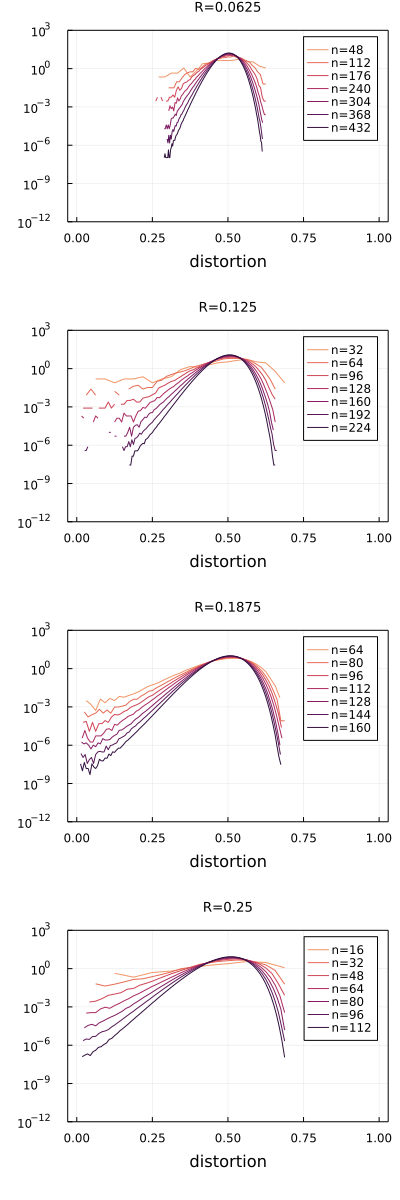

┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero valu

In [255]:
using ColorSchemes
cg = cgrad(:matter, length(ns[1])+2, categorical=true)
plts = [Plots.plot() for _ in Rs]
println("WEF wrt the zero codeword")
for (i,R) in enumerate(Rs)
   for (j,n) in enumerate(ns[i])
        maxl = maximum(length, wef_zero[i][j])
        for k in eachindex(wef_zero[i][j])
            append!(wef_zero[i][j][k], zeros(Int, -length(wef_zero[i][j][k])+maxl))
        end
        x = mean([wef_zero[i][j][k] for k in eachindex(wef_zero[i][j]) if correct[i][j][k]])
        st = j==1 ? :scatter : :line
        st = :line
       plot_wef!(plts[i], x,
            plotmin=false, seriestype = st, color=cg[j+2], framestyle=:box, bottom_margin=5Plots.mm,
            label="n=$n", title="R=$(float(R))", yaxis=(:log10, (1e-12,10^3)), titlefontsize=9, ms=1.5, msw=0) 
    end
end
plot(plts..., size=(400,1200), layout=(length(Rs),1), left_margin=5Plots.mm)

In [ ]:
savefig("wef_new.pdf");

In [ ]:
pp = plot()
cg2 = cgrad(:matter, length(Rs)+2, categorical=true)
for (j,R) in enumerate(Rs)
#     j != 3 && continue
    x = mean([wef_zero[j][end][k] for k in eachindex(wef_zero[j][end]) if correct[j][j][k]])
   plot_wef!(pp, x,
        plotmin=false, seriestype = :step, color=cg2[j+2], framestyle=:box, bottom_margin=5Plots.mm,
        label="R=$(float(R))", yaxis=(:log10, (1e-10,10^3)), titlefontsize=9, ms=1.5, msw=0) 
end
plot!(pp, title="n=$([ns[i][end] for i in eachindex(ns)])")

In [41]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()

22

In [94]:
W = 20  # 1/W is the spacing between rates
Rs = (3:5) // W
nn = 4
navg = 10 * ones(Int, nn)
nmax(R) = (25 / R ÷ W)
nmaxes(R, nn) = begin
    nm = nmax(R)
    k = max(1, round(Int, nm/nn))
    nm-nn*k+1 <= 0 && (k=1)
    [W*i for i in nm-nn*k+1:k:nm]
end
ns = [nmaxes(r, nn) for r in Rs]
nsources = 50
d = [[fill(NaN, navg[i]) for i in eachindex(ns[a])] for a in eachindex(Rs)]
wef_zero = [[[zeros(Int, ns[a][i]) for _ in 1:navg[i]] for i in eachindex(ns[a])] for a in eachindex(Rs)]
t = fill(NaN, length(ns));

In [100]:
i = 2
R = Rs[2]
n = ns[i][end]
m = round(Int, n*(1-R))
f3 = 1-3R
Λ = [0,1-f3,f3]
K = [0, 0, 1]
nedges = 3m
H = permutedims(ldpc_matrix(n,m,nedges,Λ,K));

In [101]:
R

1//5

In [102]:
using StatsBase
vardegrees = proportionmap(vec(sum(H, dims=1)))
factordegrees = proportionmap(vec(sum(H, dims=2)))

Dict{Int64, Float64} with 1 entry:
  3 => 1.0

In [103]:
vardegrees

Dict{Int64, Float64} with 2 entries:
  2 => 0.6
  3 => 0.4

In [98]:
factordegrees

Dict{Int64, Float64} with 1 entry:
  3 => 1.0

In [77]:
collect(Rs) .|> float

3-element Vector{Float64}:
 0.15
 0.2
 0.25

In [78]:
ns

3-element Vector{Vector{Int64}}:
 [20, 60, 100, 140]
 [60, 80, 100, 120]
 [40, 60, 80, 100]

In [79]:
@telegram "Exact enumeration-larger sizes -- second part" for (i,R) in enumerate(Rs)
    println("Rate $i of ", length(Rs))
    tt = @timed for (a,n) in enumerate(ns[i])
        println("### Size $a of ", length(ns[i]))
        flush(stdout)
        m = round(Int, n*(1-R))
        f3 = 1-3R
        Λ = [0,1-f3,f3]
        K = [0, 0, 1]
        nedges = 3m
        @threads for j in 1:navg[a]  
            H = permutedims(ldpc_matrix(n,m,nedges,Λ,K))
            s = [bitrand(n) for _ in 1:nsources]
            B, indep = findbasis_slow(BitMatrix(H))
            rtrue = size(B,2) // size(B,1)
            if rtrue == R
                h0, h, mins = exact_wef(B, s, showprogress=false)
                wef_zero[i][a][j] = h0
                d[i][a][j] = mean(mins)
            end
        end
    end
    t[i] = tt.time
    d
end

Rate 1 of 3
### Size 1 of 4


┌ Warning: Assignment to `m` in soft scope is ambiguous because a global variable by the same name exists: `m` will be treated as a new local. Disambiguate by using `local m` to suppress this warning or `global m` to assign to the existing global variable.
└ @ nothing In[79]:6
┌ Warning: Assignment to `f3` in soft scope is ambiguous because a global variable by the same name exists: `f3` will be treated as a new local. Disambiguate by using `local f3` to suppress this warning or `global f3` to assign to the existing global variable.
└ @ nothing In[79]:7
┌ Warning: Assignment to `Λ` in soft scope is ambiguous because a global variable by the same name exists: `Λ` will be treated as a new local. Disambiguate by using `local Λ` to suppress this warning or `global Λ` to assign to the existing global variable.
└ @ nothing In[79]:8
┌ Warning: Assignment to `K` in soft scope is ambiguous because a global variable by the same name exists: `K` will be treated as a new local. Disambiguate by usi

### Size 2 of 4
### Size 3 of 4
### Size 4 of 4
Rate 2 of 3
### Size 1 of 4
### Size 2 of 4
### Size 3 of 4
### Size 4 of 4
Rate 3 of 3
### Size 1 of 4
### Size 2 of 4
### Size 3 of 4
### Size 4 of 4


In [80]:
[Rs t]

3×2 Matrix{Float64}:
 0.15   2.25223
 0.2    9.75625
 0.25  18.969

In [81]:
d_avg = [[mean(filter(!isnan, d[a][i])) for i in eachindex(ns[a])] for a in eachindex(Rs)]
d_std = [[std(filter(!isnan, d[a][i]))/sqrt(length(filter(!isnan, d[a][i]))) for i in eachindex(ns[a])] for a in eachindex(Rs)];

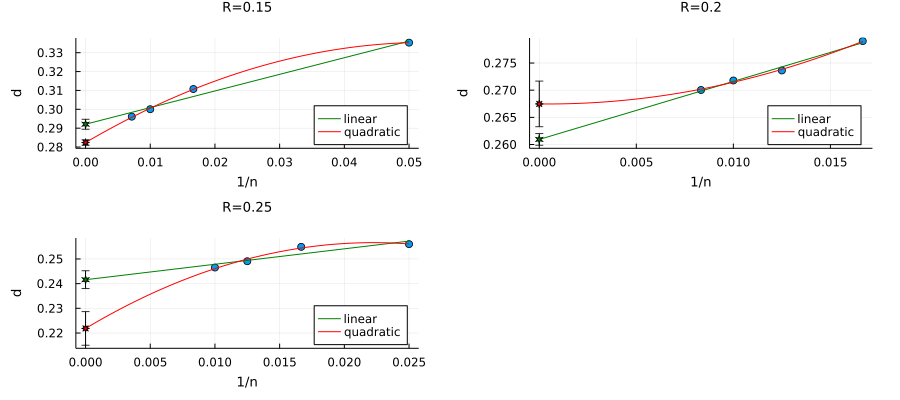

In [82]:
using DataFrames, GLM
d_avg_ = reduce(hcat, d_avg)
d_std_ = reduce(hcat, d_std)
qs = zeros(length(Rs))
qs2 = zeros(length(Rs))
ms = copy(qs)
qs_err = copy(qs)
qs2_err = copy(qs)
plts = Plots.Plot[]
for i in eachindex(Rs)
    x = 1 ./ ns[i]
    x_range = LinRange(0, maximum(x), 100)
    y = d_avg_[:,i]
    data = DataFrame(X=x, Y=y)
    ols = lm(@formula(Y ~ X), data)
    qs[i], ms[i] = coef(ols)
    qs_err[i] = stderror(ols)[1]
    ols2 = lm(@formula(Y ~ X + X^2), data)
    qs2[i], b, c = coef(ols2)
    qs2_err[i] = stderror(ols2)[1]
    plt = scatter(x, y, xlabel="1/n", ylabel="d", label="")
    plot!(plt, x_range, x_range*ms[i] .+ qs[i], title="R=$(float(Rs[i]))", titlefontsize=9, label="linear", 
        legend=:bottomright, c=:green)
    scatter!(plt, [0], [qs[i]], yerr=[qs_err[i]], c=:green, label="", m=:star6)
    plot!(plt, x_range, x_range.^2*c .+ x_range*b .+ qs2[i], title="R=$(float(Rs[i]))", titlefontsize=9, 
        label="quadratic", c=:red)
    scatter!(plt, [0], [qs2[i]], yerr=[qs2_err[i]], c=:red, label="", m=:star8, labelfontsize=9)
    push!(plts, plt)
end
plot(plts..., size=(900,400), margin=5Plots.mm)

In [83]:
ns_ = reduce(hcat, ns)

4×3 Matrix{Int64}:
  20   60   40
  60   80   60
 100  100   80
 140  120  100

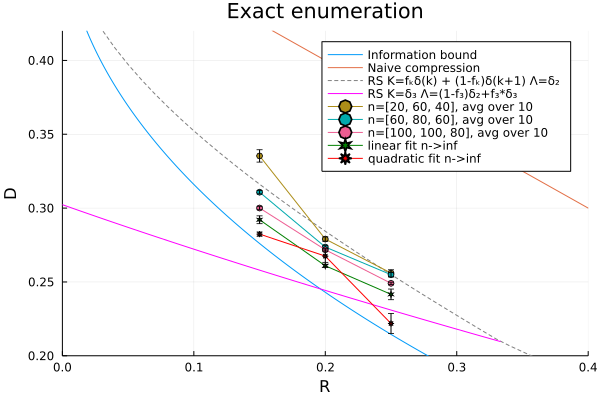

In [84]:
ns_ = reduce(hcat, ns)
pl = plot_rdb(f3=true)
for (j,n) in enumerate(ns)
    plot!(pl, Rs, d_avg_[j,:], yerr=d_std_[j,:], ms=3, label="n=$(ns_[j,:]), avg over $(navg[j])", marker=:o)
end
plot!(pl, title="Exact enumeration")
plot!(pl, Rs, qs, yerr=qs_err, ms=3, label="linear fit n->inf", marker=:star6, c=:green)
plot!(pl, Rs, qs2, yerr=qs2_err, ms=3, label="quadratic fit n->inf", marker=:star8, c=:red)
plot(pl,  xlims=(0, 0.4), ylims=(0.2, 0.42))

Runtime: 0.0 hours


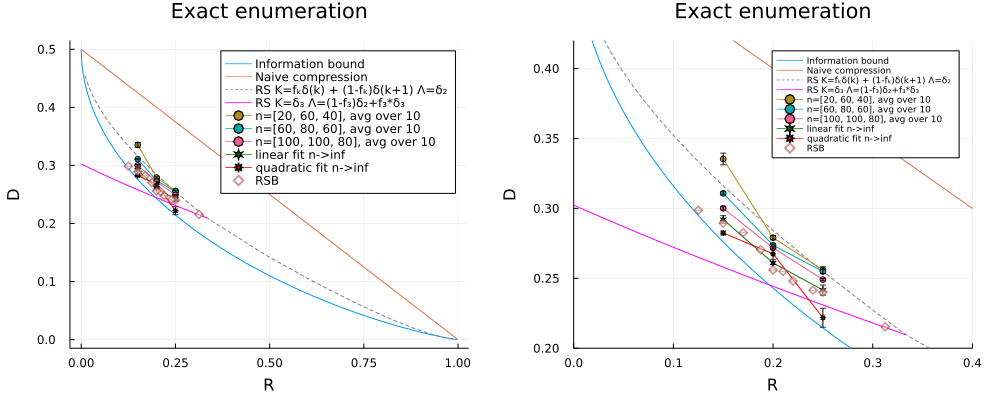

In [85]:
yopt_data = readdlm("yopt_data.txt")
t_hours = sum(t) / 3600
println("Runtime: ", round(t_hours,digits=1), " hours")
# Rs_rsb_23, Ds_rsb_23, Ds_er_rsb_23 = (0.11:0.02:0.33, [0.2977365737135704, 0.29679166785456546, 0.29575210731434554, 0.2949943231803669, 0.29397756485409976, 0.2501368753571527, 0.2411632189267363, 0.23388637157790765, 0.22714230559385223, 0.22128279206129292, 0.21565456260060245, 0.21012801774847617], [9.010253981269411e-5, 0.00018398776528276, 8.403118148946889e-5, 0.00015897456190779003, 9.16495914260236e-5, 0.0001709187426321453, 0.00017466109542782523, 0.000173980573936482, 0.0002413785375950678, 0.0003529835098745958, 0.00027606828090559466, 0.0004617280214407081])
# Rs_rsb = [0.25, 0.24, 0.22, 0.21, 0.2]
# y_rsb = vec([1.0 0.8 0.6 0.6 0.5])
# Ds_rsb = vec([0.24011787600556012 0.2414476621129465  0.24807018468086312 0.25495222929686445 0.2559480964548462])
# Ds_rsb_err = vec([0.000159658045833383    0.00017446890849328505  0.00010732745566573257  0.0001310842611345421   0.00027291305140915954])
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:]
M = readdlm("bp_dec_zeroleaves.txt")
R_bp_dec = M[:,1]
D_bp_dec_avg = M[:,2]
D_bp_dec_std = M[:,3]
plot!(pl, legendfontsize=6)
scatter!(pl, Rs_rsb, Ds_rsb, yerr=Ds_rsb_err, label="RSB", m=:diamond, msc=:brown, markeralpha=0.5, msw=2, c=:white)
pl2 = deepcopy(pl)
# plot!(pl2, Rs_rsb_23, Ds_rsb_23, m=:diamond, label="RSB y=0.5")
# scatter!(pl2, [0.24, 0.25], [0.2414, 0.2401], label="RSB", m=:diamond, msc=:brown, markeralpha=0.5, msw=2, c=:white)
plot!(pl2, xlims=(0, 0.4), ylims=(0.2, 0.42), legendfontsize=6)
# plot!(pl, R_bp_dec, D_bp_dec_avg, m=:x, label="BP+dec")
plot(pl, pl2, size=(1000,400), margin=5Plots.mm, dpi=1000)

## WEF

In [86]:
include("../code/exact_enum.jl")

plot_wef_prob (generic function with 1 method)

In [87]:
correct = [[[!isnan(d[i][j][k]) for k in 1:navg[j]] for j in eachindex(ns[i])] for i in eachindex(Rs)];

WEF wrt the zero codeword


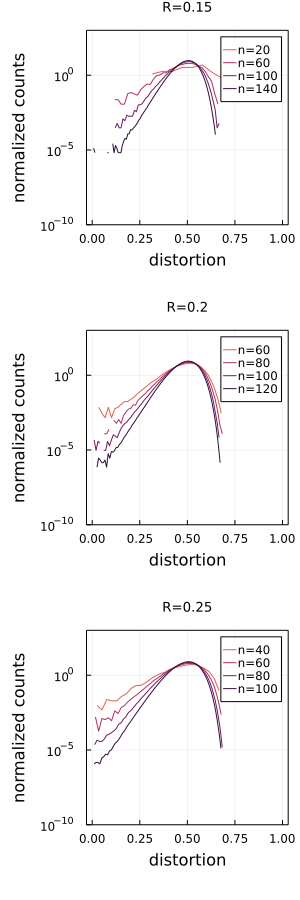

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero valu

In [93]:
using ColorSchemes
cg = cgrad(:matter, length(ns[1])+2, categorical=true)
plts = [Plots.plot() for _ in Rs]
println("WEF wrt the zero codeword")
for (i,R) in enumerate(Rs)
   for (j,n) in enumerate(ns[i])
        maxl = maximum(length, wef_zero[i][j])
        for k in eachindex(wef_zero[i][j])
            append!(wef_zero[i][j][k], zeros(Int, -length(wef_zero[i][j][k])+maxl))
        end
        x = mean([wef_zero[i][j][k] for k in eachindex(wef_zero[i][j]) if correct[i][j][k]])
        st = :line
        plot_wef!(plts[i], x[2:end], plotmin=false,
            seriestype = st, color=cg[j+2], framestyle=:box, bottom_margin=5Plots.mm,
            label="n=$n", title="R=$(float(R))", yaxis=(:log10, (1e-10,10^3)), titlefontsize=9, ms=1.5, msw=0) 
    end
end
plot(plts..., size=(300,length(Rs)*300), layout=(length(Rs),1), left_margin=10Plots.mm)

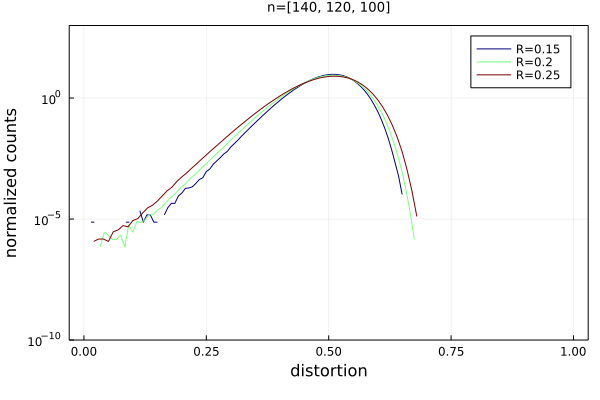

┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/crotti/.julia/packages/Plots/PomtQ/src/utils.jl:95


In [92]:
pp = plot()
cg2 = cgrad(:jet, length(Rs), categorical=true)
for (j,R) in enumerate(Rs)
    x = mean([wef_zero[j][end][k] for k in eachindex(wef_zero[j][end]) if correct[j][j][k]])
   plot_wef!(pp, x,
        plotmin=false, st=:line, color=cg2[j], framestyle=:box, bottom_margin=5Plots.mm,
        label="R=$(float(R))", yaxis=(:log10, (1e-10,10^3)), titlefontsize=9, ms=1.5, msw=0) 
end
plot!(pp, title="n=$([ns[i][end] for i in eachindex(ns)])")